# Exploring Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

## Introduction

This notebook explores Dandiset 001174, which contains calcium imaging data from supplementary motor (SMA) and primary motor areas (M1) in rhesus macaques. The researchers used one-photon microscopy with miniature microscopes to study activity patterns of projection neurons while the animals were at rest or engaged in an arm-reaching task.

> **Note**: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results and validate any findings.

### Dataset Description

*From the Dandiset metadata:* 
The study of motor cortices in non-human primates is relevant to our understanding of human motor control, both in healthy conditions and in movement disorders. Calcium imaging and miniature microscopes allow the study of multiple genetically identified neurons with excellent spatial resolution. This dataset contains recordings where researchers implanted gradient index lenses and expressed GCaMP6f to image calcium transients while the animals were at rest or engaged in an arm reaching task.

The data spans four rhesus macaque subjects, with recordings from the supplementary motor area (SMA) and primary motor cortex (M1). Researchers tracked neuronal activity across conditions and examined cell pairs for synchronous activity.

### Technical Information

- **Measurement technique**: One-photon calcium imaging
- **Subjects**: 4 rhesus macaques
- **Recording areas**: SMA and M1
- **Calcium indicator**: GCaMP6f
- **Lens type**: GRIN lens

## Setup

First, we'll import the necessary libraries for data analysis and visualization.

*Note: This notebook assumes you have the following packages installed: `pynwb`, `lindi`, `numpy`, `matplotlib`, `pandas`, `seaborn`, and `dandi`. If you don't have them installed, please install them using pip.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pynwb
import lindi
import seaborn as sns
from dandi.dandiapi import DandiAPIClient

# Set up visualization defaults
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 8)

## Exploring the Dandiset

Let's start by retrieving the list of assets in the Dandiset to understand what files are available.

In [2]:
# Connect to the DANDI API and get the Dandiset information
client = DandiAPIClient()
dandiset = client.get_dandiset("001174")
assets = list(dandiset.get_assets())

print(f"Total number of files: {len(assets)}")

# Extract basic information about the files
file_info = []
for asset in assets:
    path = asset.path
    subject_id = path.split('/')[0].replace('sub-', '')
    session = "unknown"
    if "ses-" in path:
        session = path.split('_')[1].replace('ses-', '')
    size_mb = asset.size / (1024 * 1024)  # Convert to MB
    
    file_info.append({
        'subject_id': subject_id,
        'session': session,
        'path': path,
        'size_mb': size_mb
    })

# Create a DataFrame for easier manipulation
files_df = pd.DataFrame(file_info)

# Display the number of files per subject
print("\nFiles per subject:")
print(files_df['subject_id'].value_counts())

Total number of files: 45

Files per subject:
subject_id
U    18
Q    14
F     9
V     4
Name: count, dtype: int64


### File Distribution by Subject

Now let's visualize how the files are distributed across subjects and their sizes.

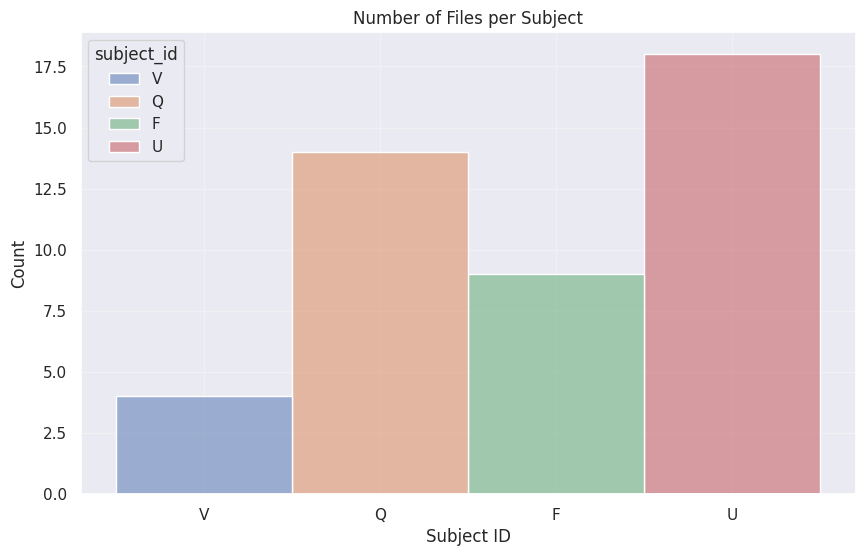

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(data=files_df, x='subject_id', hue='subject_id')
plt.title('Number of Files per Subject')
plt.xlabel('Subject ID')
plt.ylabel('Count')
plt.grid(alpha=0.3)

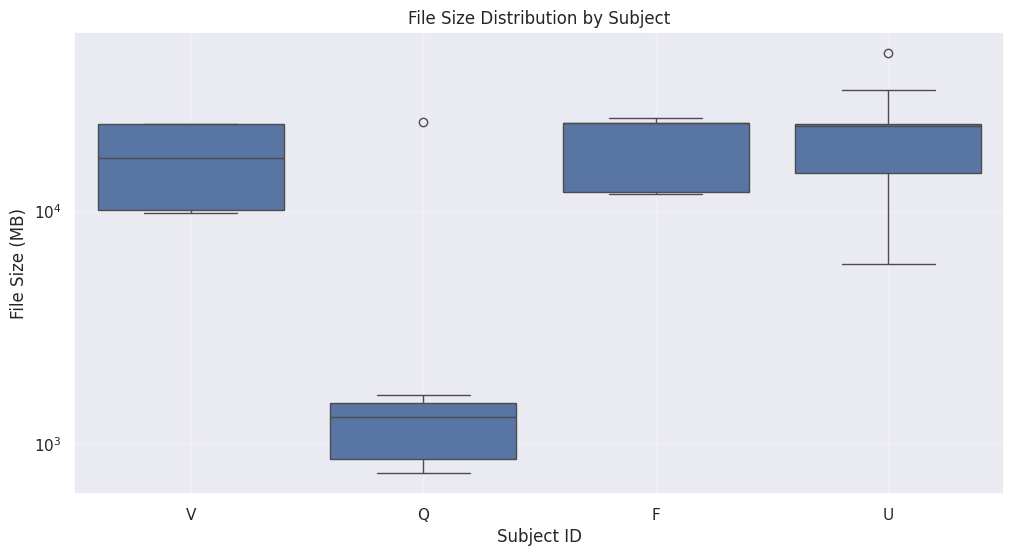

In [4]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=files_df, x='subject_id', y='size_mb')
plt.title('File Size Distribution by Subject')
plt.xlabel('Subject ID')
plt.ylabel('File Size (MB)')
plt.grid(alpha=0.3)
plt.yscale('log')  # Use log scale for better visualization

The plots above show the distribution of files across subjects and their sizes. We can see that the dataset contains data from multiple subjects, with varying file sizes due to different recording durations and conditions.

## Loading and Exploring a Single NWB File

Let's load a single NWB file from the Dandiset to explore the structure of the data in more detail. We'll use the `lindi` package to load the file, which allows efficient remote access to the data.

In [5]:
# Load an example NWB file (subject Q)
# We use a specific API to access the remote NWB file
lindi_url = "https://lindi.neurosift.org/dandi/dandisets/001174/assets/de07db56-e7f3-4809-9972-755c51598e8d/nwb.lindi.json"
f = lindi.LindiH5pyFile.from_lindi_file(lindi_url)
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Display basic metadata
print(f"Session description: {nwb.session_description}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Species: {nwb.subject.species}")
print(f"Age: {nwb.subject.age}")
print(f"Sex: {nwb.subject.sex}")
print(f"Session start time: {nwb.session_start_time}")

Session description: Calcium imaging in SMA during the spontaneous condition
Subject ID: Q
Species: Macaca mulatta
Age: P5Y
Sex: F
Session start time: 2022-09-15 13:16:33.129000+00:00


### NWB File Structure

Now, let's explore the structure of the NWB file to understand what types of data are available.

In [6]:
# Check available acquisition data
print("Available acquisition data:")
for name in nwb.acquisition:
    data = nwb.acquisition[name]
    print(f"  - {name} ({type(data).__name__})")
    # For OnePhotonSeries, show more details
    if isinstance(data, pynwb.ophys.OnePhotonSeries):
        print(f"    - Shape: {data.data.shape}")
        print(f"    - Rate: {data.rate} Hz")

# Check available processing modules
print("\nAvailable processing modules:")
for module_name in nwb.processing:
    module = nwb.processing[module_name]
    print(f"  - {module_name} ({type(module).__name__})")
    for interface_name in module.data_interfaces:
        interface = module.data_interfaces[interface_name]
        print(f"    - {interface_name} ({type(interface).__name__})")

Available acquisition data:
  - OnePhotonSeries (OnePhotonSeries)
    - Shape: (6041, 320, 200)
    - Rate: 10.01 Hz

Available processing modules:
  - ophys (ProcessingModule)
    - EventAmplitude (RoiResponseSeries)
    - Fluorescence (Fluorescence)
    - ImageSegmentation (ImageSegmentation)


The NWB file contains one-photon calcium imaging data recorded from the supplementary motor area (SMA) during a spontaneous condition (no task). The data is organized into three main components:

1. **OnePhotonSeries**: Raw imaging data from the calcium imaging microscope
2. **ImageSegmentation**: Contains the ROI (Region of Interest) masks identifying individual cells
3. **Fluorescence**: Calcium fluorescence traces extracted from each ROI
4. **EventAmplitude**: Detected calcium transient events from each ROI

## Visualizing Calcium Imaging Data

Let's examine the one-photon imaging data to get a sense of what the raw recordings look like.

OnePhotonSeries shape: (6041, 320, 200)
Number of frames: 6041
Frame dimensions: 320 x 200
Image rate: 10.01 Hz
Total recording duration: 603.50 seconds


/tmp/ipykernel_97630/3976211563.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


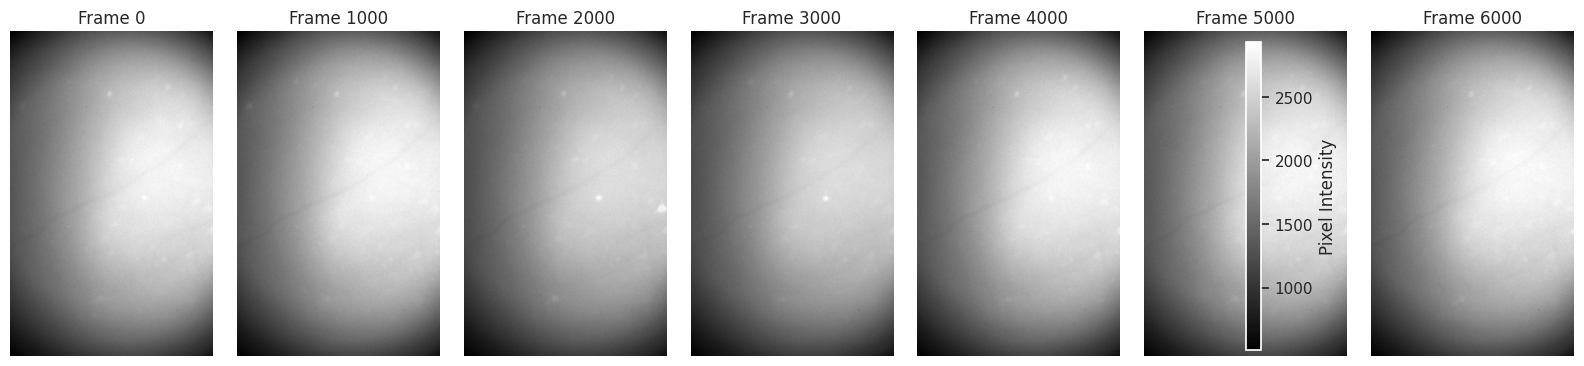

In [7]:
# Access the OnePhotonSeries data
one_photon_series = nwb.acquisition["OnePhotonSeries"]
print(f"OnePhotonSeries shape: {one_photon_series.data.shape}")
print(f"Number of frames: {one_photon_series.data.shape[0]}")
print(f"Frame dimensions: {one_photon_series.data.shape[1]} x {one_photon_series.data.shape[2]}")
print(f"Image rate: {one_photon_series.rate} Hz")
print(f"Total recording duration: {one_photon_series.data.shape[0] / one_photon_series.rate:.2f} seconds")

# Get a subset of frames for visualization
# Sampling every 1000th frame to get a representative view
sample_indices = np.arange(0, one_photon_series.data.shape[0], 1000)
sample_frames = [one_photon_series.data[i, :, :] for i in sample_indices]

# Plot sample frames
fig, axes = plt.subplots(1, len(sample_frames), figsize=(16, 5))
for i, (ax, frame) in enumerate(zip(axes, sample_frames)):
    im = ax.imshow(frame, cmap='gray')
    ax.set_title(f'Frame {sample_indices[i]}')
    ax.axis('off')

plt.colorbar(im, ax=axes, label='Pixel Intensity', shrink=0.8)
plt.tight_layout()
plt.show()

### Visualizing ROI Masks

Now let's examine the segmented cells (ROIs) identified in the imaging data.

Number of ROIs: 40
Mask dimensions: 292 x 179


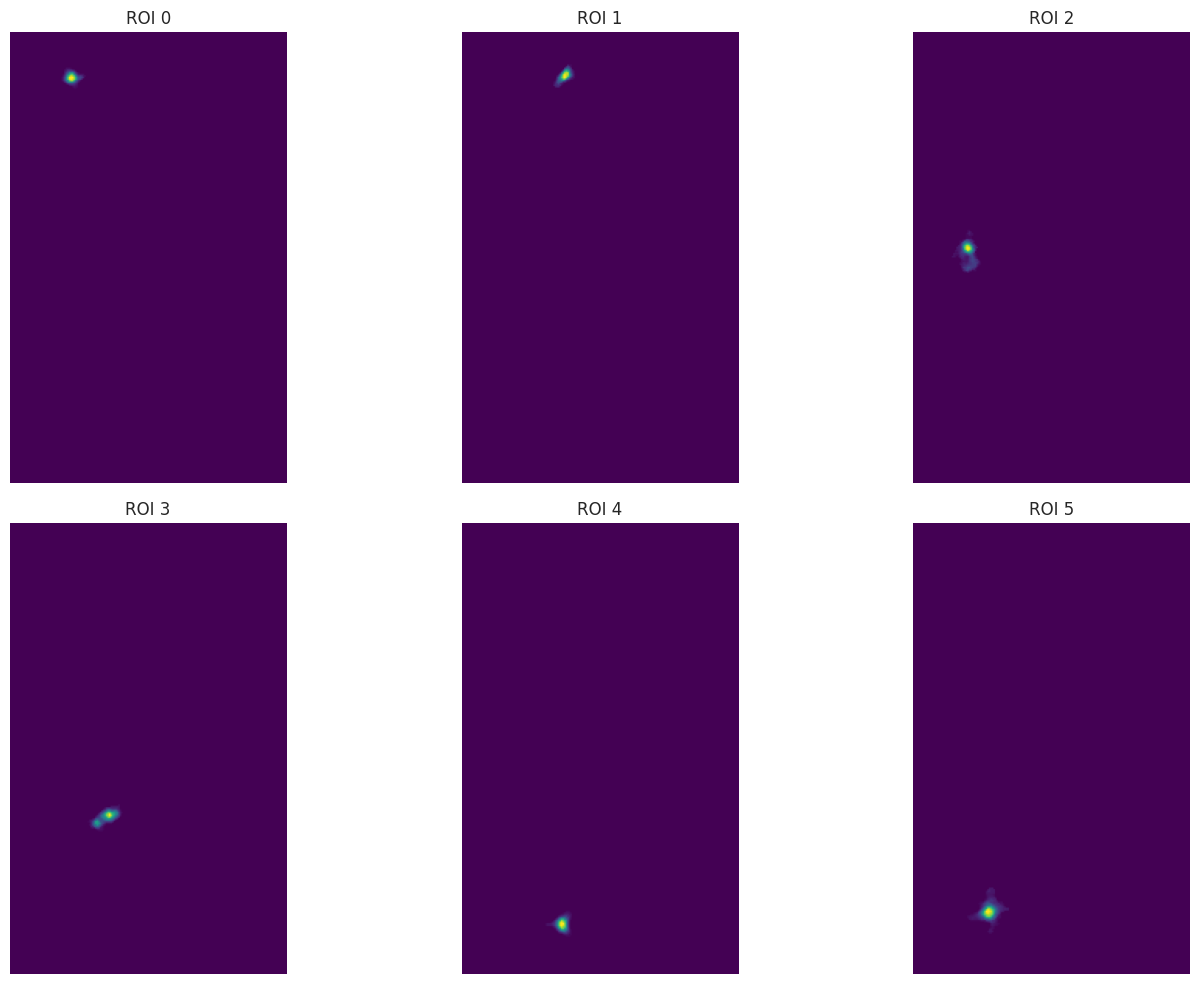

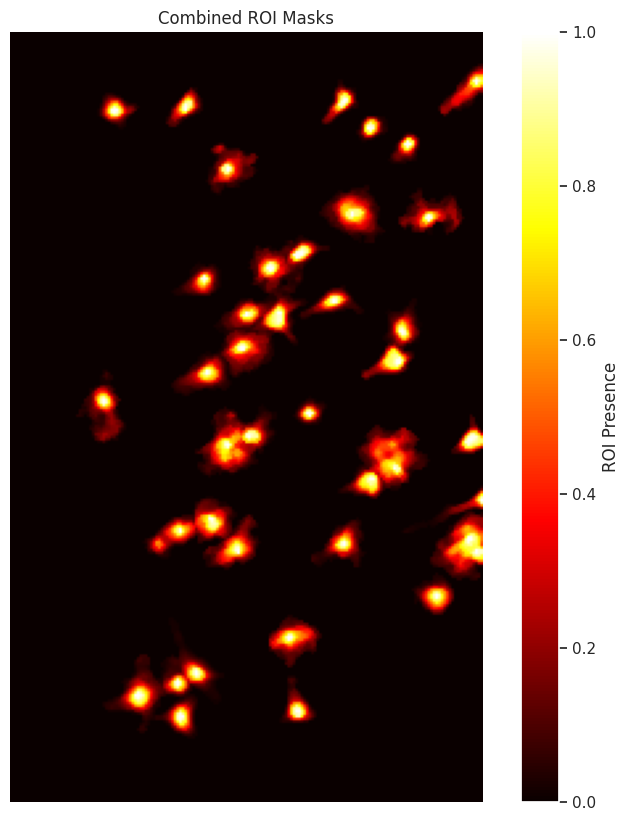

In [8]:
# Get the ROI masks from the PlaneSegmentation data
plane_seg = nwb.processing["ophys"]["ImageSegmentation"]["PlaneSegmentation"]
image_masks = plane_seg["image_mask"].data

print(f"Number of ROIs: {image_masks.shape[0]}")
print(f"Mask dimensions: {image_masks.shape[1]} x {image_masks.shape[2]}")

# Plot a subset of ROI masks
num_rois_to_plot = min(6, image_masks.shape[0])
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_rois_to_plot):
    axes[i].imshow(image_masks[i], cmap='viridis')
    axes[i].set_title(f'ROI {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Create a combined mask of all ROIs for visualization
combined_mask = np.zeros_like(image_masks[0])
for i in range(image_masks.shape[0]):
    combined_mask = np.maximum(combined_mask, image_masks[i])

plt.figure(figsize=(10, 10))
plt.imshow(combined_mask, cmap='hot')
plt.colorbar(label='ROI Presence')
plt.title('Combined ROI Masks')
plt.axis('off')
plt.show()

The ROI masks show the spatial location of individual cells in the field of view. Each ROI represents a cell or neural process that was identified during segmentation. These ROIs will be used to extract fluorescence traces from the raw imaging data.

## Analyzing Calcium Activity

Now let's analyze the calcium fluorescence traces extracted from each ROI.

Fluorescence data shape: (6041, 40)
Number of ROIs: 40
Sampling rate: 10.01 Hz
Duration: 603.50 seconds


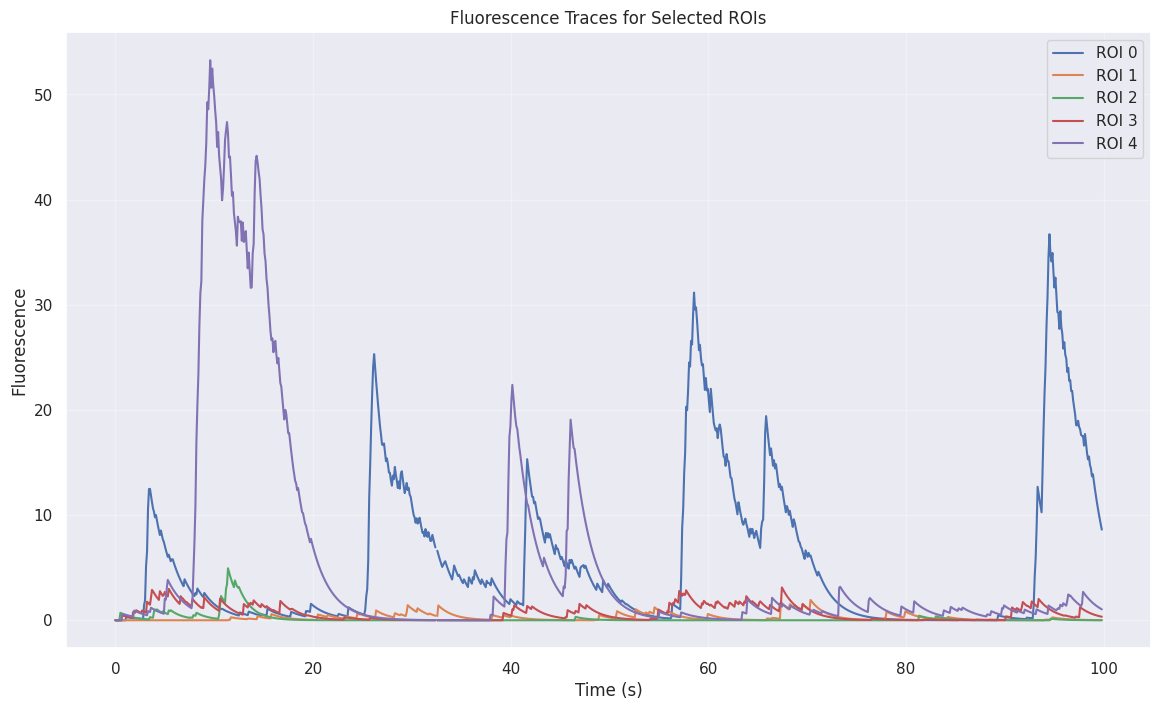

In [9]:
# Get the fluorescence data
fluor = nwb.processing["ophys"]["Fluorescence"]["RoiResponseSeries"]
print(f"Fluorescence data shape: {fluor.data.shape}")
print(f"Number of ROIs: {fluor.data.shape[1]}")
print(f"Sampling rate: {fluor.rate} Hz")
print(f"Duration: {fluor.data.shape[0] / fluor.rate:.2f} seconds")

# Plot fluorescence traces for a few ROIs
# Sample for visualization (first 1000 timepoints)
num_rois_to_plot = 5
timepoints = np.arange(1000)
times = timepoints / fluor.rate

plt.figure(figsize=(14, 8))
for i in range(num_rois_to_plot):
    plt.plot(times, fluor.data[timepoints, i], label=f'ROI {i}')

plt.xlabel('Time (s)')
plt.ylabel('Fluorescence')
plt.title('Fluorescence Traces for Selected ROIs')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Calcium Event Analysis

Now let's look at the detected calcium events, which represent neuronal activity.

Event amplitude data shape: (6041, 40)


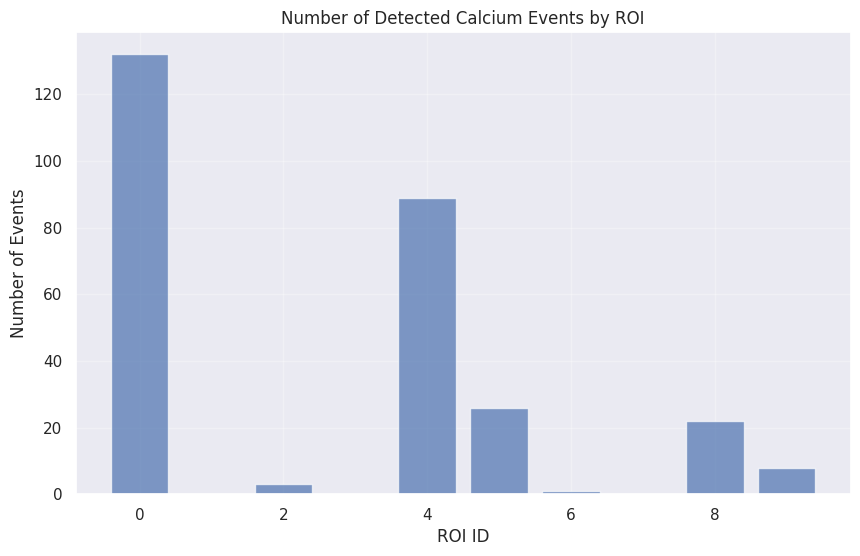

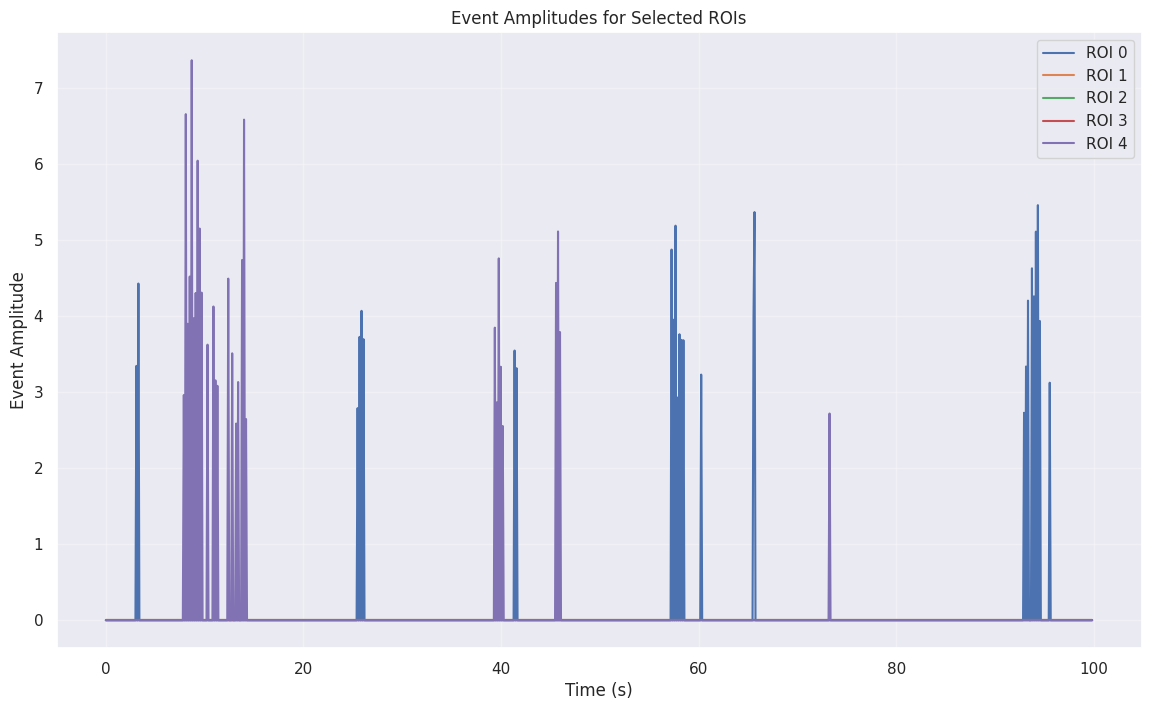

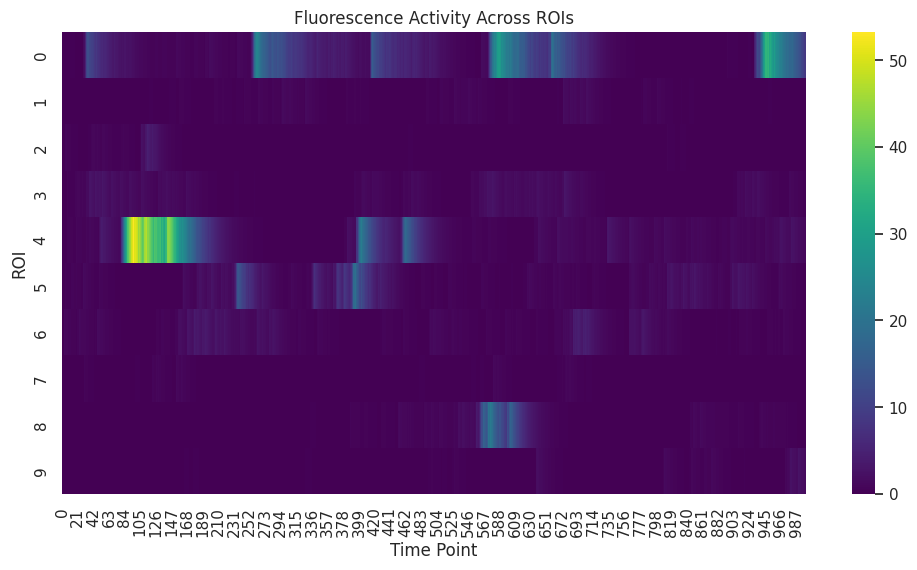

In [10]:
# Get the event amplitude data
event_amp = nwb.processing["ophys"]["EventAmplitude"]
print(f"Event amplitude data shape: {event_amp.data.shape}")

# Calculate the number of events per ROI
n_rois = min(10, event_amp.data.shape[1])  # Limit to first 10 ROIs
num_events = []

for i in range(n_rois):
    # Count events (non-zero values)
    events = event_amp.data[:, i]
    count = np.sum(events > 0)
    num_events.append(count)

# Plot the number of events per ROI
plt.figure(figsize=(10, 6))
plt.bar(np.arange(n_rois), num_events, alpha=0.7)
plt.xlabel('ROI ID')
plt.ylabel('Number of Events')
plt.title('Number of Detected Calcium Events by ROI')
plt.grid(alpha=0.3)
plt.show()

# Plot event amplitudes for a few ROIs (first 1000 timepoints)
plt.figure(figsize=(14, 8))
for i in range(min(5, event_amp.data.shape[1])):  # Plot first 5 ROIs
    plt.plot(times, event_amp.data[timepoints, i], label=f'ROI {i}')

plt.xlabel('Time (s)')
plt.ylabel('Event Amplitude')
plt.title('Event Amplitudes for Selected ROIs')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Create a heatmap of activity across ROIs
time_subset = fluor.data[:1000, :n_rois].T

plt.figure(figsize=(12, 6))
sns.heatmap(time_subset, cmap='viridis')
plt.xlabel('Time Point')
plt.ylabel('ROI')
plt.title('Fluorescence Activity Across ROIs')
plt.show()

## Summary and Conclusions

In this notebook, we explored Dandiset 001174, which contains calcium imaging data from the supplementary motor (SMA) and primary motor areas (M1) in rhesus macaques. Here's a summary of our observations:

1. **Dataset Content**: The dataset includes one-photon calcium imaging recordings from 4 subjects, with files of varying sizes representing different recording sessions.

2. **Data Structure**: Each NWB file contains:
   - Raw one-photon imaging data
   - Segmented ROIs representing individual cells
   - Fluorescence traces extracted from each ROI
   - Detected calcium events

3. **Activity Patterns**: Our analysis showed significant variations in activity across different ROIs, with some cells exhibiting many more calcium events than others. This heterogeneity suggests functional specialization within the motor cortex.

4. **ROI Distribution**: The ROI masks revealed the spatial distribution of cells in the field of view, with some clustering patterns visible.

5. **Event Detection**: The calcium event detection allowed us to identify specific points of neural activation, which could be correlated with behavioral events in future analyses.

### Future Directions

This exploration provides a foundation for more detailed analyses, such as:

- Correlating calcium activity with specific behavioral events during the reaching task
- Comparing activity patterns between SMA and M1 regions
- Examining synchronous activity between cell pairs
- Analyzing sequential activation patterns mentioned in the study description

The dataset provides a rich resource for studying motor cortex activity in non-human primates during both rest and task conditions, offering insights into neural mechanisms of motor control relevant to both basic neuroscience and understanding movement disorders.

This notebook was created using dandi-notebook-gen, an AI-powered system for generating exploratory notebooks for Dandisets. The notebook provides a starting point for exploration, but users should validate findings and adapt analyses for their specific research questions.